# Gini Feature Importance for Decison Trees and Ensembles of Trees

With decision trees, there are a few ways feature importance can be calculated.

In [1]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import graphviz
import numpy as np

In [2]:
X, y = make_classification(n_samples=10,
                           n_features=5,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False,
                           )
X

array([[ 0.25505156, -0.5652961 , -2.17026121, -0.35362786, -0.74074747],
       [-0.32393187, -0.90590188, -2.24490763, -0.67502183, -0.13278426],
       [ 0.28806083,  0.70623367, -1.02620405,  0.61980106,  1.79116846],
       [ 0.61253165, -0.37773326, -1.82401806,  0.17100044, -1.72567135],
       [-2.19599106,  1.86300361, -0.64939349,  0.16065854, -0.85898532],
       [ 0.76200858,  0.26922756, -0.23828011, -0.20642094,  0.48842647],
       [-1.46191431, -1.69842329,  2.41649117, -0.83833097,  0.38116374],
       [-3.16147408, -0.33172241,  0.66478335, -0.99090328,  1.01788005],
       [ 2.03945994,  1.85498036,  1.84218187,  0.3415874 , -1.25088622],
       [ 2.9519817 ,  2.20047613,  0.91542817,  0.92525075, -0.90478616]])

We make some random data for a binary classification, 10 samples with 5 features, of which 3 are informative.
We will then train a model. This same method of calculating feature importance would work for a single decision tree, or an ensemble method, such as Bagging, Random Forests or Gradient Boosting. Here we'll use Random Forests.

In [3]:
rf = RandomForestClassifier(criterion='gini',random_state=0, n_estimators=5).fit(X, y)

We'll fit a tree using Gini. Scikit learn supports either Gini, or Entropy. With scikit learn's default feature importance, the criterion used to fit the tree is the same criterion used to evaluate feature importance, but in theory this isn't necessary. It is possible to fit a tree using one metric, and evaluate feature importances with another.

The Gini metric (or impurity) for binary classification is defined as follows- suppose at a leaf of a tree we have $a$ samples of one class, and $b$ of the other, where $a>b$. Then the probability we would get from that leaf is a probability $\frac{a}{a+b}$ of majority class, and $\frac{b}{a+b}$ of the other. The Gini metric is defined as 

$$\frac{1}{a+b}\sum_i P(\text{Incorrect prediction of item } i)$$ 

So in our set up, for $b$ of the items, the probabililty of missclassification is $\frac{a}{a+b}$, and for $a$ it is $\frac{b}{a+b}$, giving $$\frac{2ab}{(a+b)^2}  $$


[0.625 0.375 0.    0.    0.   ]


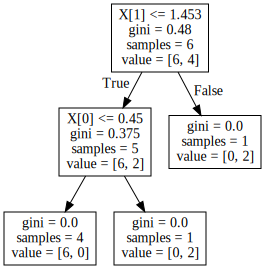

In [4]:
def visualise_estimator(model, index):
    tree = model.estimators_[index]
    print(tree.feature_importances_)
    return graphviz.Source(export_graphviz(tree))
visualise_estimator(rf, 0)

This is the first decision tree that has been trained by our random forest. For the first split, we have 6 samples of one class, 4 of the other. So for 6 samples we missclassify with probability $0.4$, for 4 categories with probability $0.6$, giving us a Gini of $\tfrac{1}{10}(6 \cdot 0.4 + 4 \cdot0.6) = 0.48$ as shown at that split.

The Gini at the other splits can be worked out similarly. For feature importance, mean decrease in impurity is used. So to evaluate the splits, this formula is used 
$$\frac{\text{Data in split}}{\text{Total data}} \left( \text{Data fraction in left} \cdot \text{Decrease in metric in left} + \text{Data fraction in right} \cdot \text{Decrease in metric in right} \right) $$

That's quite long winded, but an example should make it clearer. Let's evaluate the first split. So this split separates all 10 if our training cases. The left split has 8 samples, and the right split the other 2. On the left side, the decrease in metric is $0.48-0.375$, and on the right it is $0.48-0$. So the total evaluation of that split is $$\frac{10}{10} (0.8 \cdot  (0.48-0.375) + 0.2 \cdot(0.48-0))=0.18$$

In a similar fashion the second split has a score $$\frac{8}{10} (0.75\cdot(0.375-0)+0.25\cdot(0.375))=0.3$$

This is all the splits on our tree, but for a large tree we would work out this value for every split. Then for each feature, would sum this value for each split in which that feature occurs. So in this tree feature 1 has a score of $0.18$, and feature 0 a score of $0.3$.

The last step is normalisation. So the final score for features 1 is $\frac{0.18}{0.18+0.3}=0.325$, and for feature 0, $0.675$.

We'll compare this with the scikit learn feature importances for that tree.

In [5]:
print(rf.estimators_[0].feature_importances_)

[0.625 0.375 0.    0.    0.   ]


And we see the results are identical. Worth reiterating the point above- nothing about the above importance calculation depends on Gini specifically, and could be done with any other metric evaluating each split.

We can do the same calculations for the other trees in random forest.

In [6]:
importance_list = []
for i, estimator in enumerate(rf.estimators_):
    print("Tree {} has importances {}".format(i, estimator.feature_importances_))
    importance_list.append(estimator.feature_importances_)

Tree 0 has importances [0.625 0.375 0.    0.    0.   ]
Tree 1 has importances [0. 0. 0. 1. 0.]
Tree 2 has importances [0. 0. 0. 1. 0.]
Tree 3 has importances [0.375 0.    0.    0.625 0.   ]
Tree 4 has importances [0.         0.55555556 0.         0.         0.44444444]


The last step is nice and simple, for each feature we take the average of the values for each tree, then will compare with the scikit learn values.

In [7]:
mean_importance = np.mean(np.asanyarray(importance_list), axis=0)
print(mean_importance)
print(rf.feature_importances_)

[0.2        0.18611111 0.         0.525      0.08888889]
[0.2        0.18611111 0.         0.525      0.08888889]


And we see everything matches up nicely. It's worth mentioning at least one method of feature importance, not used by scikit learn but common for Random Forests, the permutation method. The idea is we permute the values of a given feature within a column, if it's important we will lose predictive power and should see a corresponding difference in the quality of the train model, but if it's not important, we should see less (or possibly no) change.